# ch01.04 DNN기초 - 이진분류 모델


---
* 날짜: 2022-06-28
* 이름: 고민수

## 학습내용
    - 딥러닝을 이용한 이진분류 모델 구현
    - 적절한 손실함수와 최적화 함수 정의
    - 평가 및 예측

## 학습자료

* 모두의딥러닝 11장, 13장
* 데이터
  * `sornar.csv`
  * `pima-indians-diabetes.csv`


```
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
seed=1
np.random.seed(seed)
tf.random.set_seed(seed)
```

```
https://github.com/yebiny/SkillTreePython-DeepLearning.git
```

In [2]:
import set_matplotlib_hangul

Hangul OK in your window!


In [8]:
import warnings
warnings.filterwarnings(action='ignore')

plt.rc("axes", unicode_minus=False) # 음수값 깨지는 폰트 설정
pd.options.display.max_columns = 20 # 칼럼수 50개까지

show = {"show_shapes":True, "show_dtype":True, "show_layer_names":True, "show_layer_activations":True}

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
seed=1
np.random.seed(seed)
tf.random.set_seed(seed)

## 소나 데이터 광물 예측
---

> 1988년 존스홉킨스 대학교의 세즈노프스키(Sejnowski) 교수는 광석과 일반 돌을 가져다 놓고 음파 탐지기를 쏜 후 그 결과를 데이터를 정리했습니다. 신경망이 광석과 돌을 얼마나 잘 구분하는지 알아보도록 합시다.

```
- 0~59 : 음파 탐지기를 이용해 얻은 값
- 60: 광석 구분 {R, M}
```
<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0104-01.PNG?raw=true width=450>
</p>




### | 데이터 준비

#### **데이터 로드**
* `sonar.csv`

In [10]:
df = pd.read_csv("../../dataset/preprocessed/sonar.csv", header=None)
print(df.shape)
df

(208, 61)


,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,0.0187,0.0346,0.0168,0.0177,0.0393,0.1630,0.2028,0.1694,0.2328,0.2684,...,0.0116,0.0098,0.0199,0.0033,0.0101,0.0065,0.0115,0.0193,0.0157,M
204,0.0323,0.0101,0.0298,0.0564,0.0760,0.0958,0.0990,0.1018,0.1030,0.2154,...,0.0061,0.0093,0.0135,0.0063,0.0063,0.0034,0.0032,0.0062,0.0067,M
205,0.0522,0.0437,0.0180,0.0292,0.0351,0.1171,0.1257,0.1178,0.1258,0.2529,...,0.0160,0.0029,0.0051,0.0062,0.0089,0.0140,0.0138,0.0077,0.0031,M
206,0.0303,0.0353,0.0490,0.0608,0.0167,0.1354,0.1465,0.1123,0.1945,0.2354,...,0.0086,0.0046,0.0126,0.0036,0.0035,0.0034,0.0079,0.0036,0.0048,M


#### **데이터 전처리**

In [15]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

def path2data_sona(path, seed=1):
    # 데이터 적절히 불러오기
    df = pd.read_csv(
        data_path,
        header=None,  # 첫번째 행이 데이터(컬럼이 없음)
    )
    
    # x-y 분할 (values를 통해 numpy로 가져옴)
    x = df.values[:, :-1]  # 모든행(샘플), 0부터12까지 열(속성)
    y = df.values[:, -1]  # 모든행(샘플), 13번째 열(속성)
    
    # scaling (x의 모든속성)
    scaler = StandardScaler()
    x = scaler.fit_transform(x)

    # label_encoding (y)
    labeling = LabelEncoder()
    y = labeling.fit_transform(y)

    # train-test 데이터 분할
    x_train, x_test, y_train, y_test = train_test_split(x,
                                                        y,
                                                        test_size=0.2,
                                                        stratify=y,
                                                        random_state=seed)
    return x_train, x_test, y_train, y_test


data_path = "../../dataset/preprocessed/sonar.csv"
x_train, x_test, y_train, y_test = path2data_sona(data_path)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
print(x_train[1], y_train[1])

(166, 60) (42, 60) (166,) (42,)
[-0.49983222 -0.25658101 -0.3921212  -0.31222667 -0.2201866  -0.88140067
 -0.85897691 -0.84168755 -0.97883716 -1.09595572 -0.51375055  0.69688292
  1.29989349  1.35442271  1.51561473  1.47190042  0.37756954 -0.2702886
 -0.93411793 -0.87224661 -0.47652108  0.15092025  0.36832867  1.04236156
  1.32839681  0.3174794  -0.58292446 -0.32467513  0.92387253  0.35542998
 -0.12870439  0.27857552 -0.40880204 -0.41456169 -0.40606454 -0.61577476
 -1.18832073 -1.31486515 -1.112309   -1.40607397 -0.79819858 -1.0693377
 -0.5931235  -0.18030363 -0.5720626   0.23252344  0.27952675 -0.83871818
 -0.45525544  0.48238715  0.06104129 -0.33505976  0.21167007 -0.8980716
 -0.25321639  0.73018924  0.36035381 -0.34845747 -0.76888703 -0.91796599] 1


* 예측값 분포 확인

Text(0.5, 1.0, 'testset')

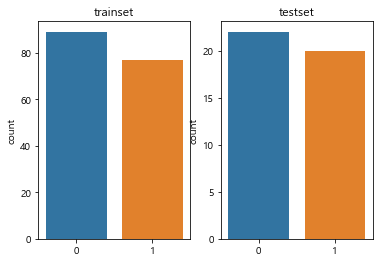

In [16]:
plt.subplot(121)
sns.countplot(x=y_train)
plt.title("trainset")
plt.subplot(122)
sns.countplot(x=y_test)
plt.title("testset")

### | 모델


<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0104-02.PNG?raw=true width=500>
</p>


#### **모델 생성**

In [27]:
from tensorflow.keras import models, layers, utils

def build_model():
    x = layers.Input(shape=(60, ))  # 데이터가 주어지면 인풋의 shape는 고정
    z = layers.Dense(30, activation='relu')(x)
    y = layers.Dense(1, activation="sigmoid")(z)  # 데이터가 주어지면 아웃풋의  shape는 고정
    #( 이진분류문제는 마지막 아웃풋 shape가 1)
    model = models.Model(x, y, name='sona_classifier')
    return model

#### **모델 시각화**

* `model.summary()`
* `utils.plot_model()`

Model: "sona_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 60)]              0         
                                                                 
 dense_4 (Dense)             (None, 30)                1830      
                                                                 
 dense_5 (Dense)             (None, 1)                 31        
                                                                 
Total params: 1,861
Trainable params: 1,861
Non-trainable params: 0
_________________________________________________________________


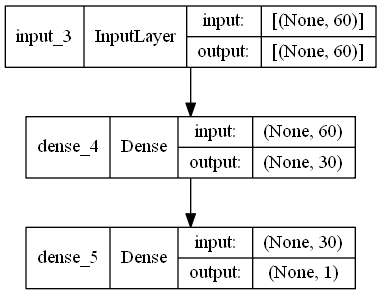

In [28]:
model = build_model()
model.summary()
utils.plot_model(model, show_shapes=True)

### | 학습

#### **모델 컴파일**

```
model.compile(loss, optimizer, metrics) 
```
* `loss` : "binary_crossentropy"
* `optimizer` : "adam"
* `metrics`: "accuracy"


In [29]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

#### **학습**

```
model.fit(x_train, y_train, epochs, batch_size)
```
* `x_train` : 넘파이 혹은 텐서 형식의 인풋 데이터
* `y_train` : 넘파이 혹은 텐서 형식의 아웃풋 데이터
* `epochs` : 학습 횟수
* `batch_size` : 배치 사이즈 (업데이트 한번에 사용될 샘플 개수)

In [30]:
model.fit(x_train, y_train, epochs=100, batch_size=16, verbose=2)

Epoch 1/100
11/11 - 0s - loss: 0.7068 - accuracy: 0.5663 - 322ms/epoch - 29ms/step
Epoch 2/100
11/11 - 0s - loss: 0.5852 - accuracy: 0.7108 - 27ms/epoch - 2ms/step
Epoch 3/100
11/11 - 0s - loss: 0.5060 - accuracy: 0.7831 - 14ms/epoch - 1ms/step
Epoch 4/100
11/11 - 0s - loss: 0.4544 - accuracy: 0.8133 - 13ms/epoch - 1ms/step
Epoch 5/100
11/11 - 0s - loss: 0.4168 - accuracy: 0.8434 - 12ms/epoch - 1ms/step
Epoch 6/100
11/11 - 0s - loss: 0.3868 - accuracy: 0.8795 - 13ms/epoch - 1ms/step
Epoch 7/100
11/11 - 0s - loss: 0.3614 - accuracy: 0.8855 - 14ms/epoch - 1ms/step
Epoch 8/100
11/11 - 0s - loss: 0.3374 - accuracy: 0.8916 - 19ms/epoch - 2ms/step
Epoch 9/100
11/11 - 0s - loss: 0.3156 - accuracy: 0.9096 - 18ms/epoch - 2ms/step
Epoch 10/100
11/11 - 0s - loss: 0.2979 - accuracy: 0.9277 - 19ms/epoch - 2ms/step
Epoch 11/100
11/11 - 0s - loss: 0.2808 - accuracy: 0.9277 - 19ms/epoch - 2ms/step
Epoch 12/100
11/11 - 0s - loss: 0.2644 - accuracy: 0.9398 - 15ms/epoch - 1ms/step
Epoch 13/100
11/11 - 0s

### | 검증 및 예측


#### **검증**

```
model.evaluate(x_test, y_test)
```
* `x_test` : 넘파이 혹은 텐서 형식의 인풋 테스트 데이터
* `y_test` : 넘파이 혹은 텐서 형식의 아웃풋 테스트 데이터

In [31]:
model.evaluate(x_test, y_test)

2/2 [==============================] - 0s 0s/step - loss: 0.3921 - accuracy: 0.8810


[0.39210155606269836, 0.8809523582458496]

#### **예측**

```
model.predict(x_test)
```
* `x_test` : 넘파이 혹은 텐서 형식의 인풋 테스트 데이터
* `y_test` : 넘파이 혹은 텐서 형식의 아웃풋 테스트 데이터

In [33]:
y_pred = model.predict(x_test).flatten()
print(y_pred[0], y_test[0])
y_pred.shape, y_test.shape

0.93730855 1


((42,), (42,))

* 예측 시각화

[[20  2]
 [ 3 17]]


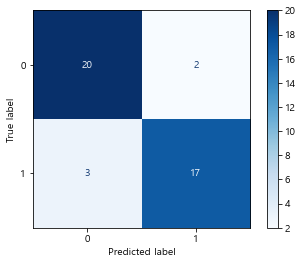

In [40]:
# 혼돈행렬 만들기
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# confusion_matrix는 정수값이 들어가야함
cm = confusion_matrix(y_test, np.round(y_pred))
print(cm)
ConfusionMatrixDisplay(cm).plot(cmap="Blues");

## 과제
---

### | 과제1. 이진분류 문제 정리

* 예측값의 범위 : 0 에서 1사이의 확률 값
* 예측값의 shape : (샘플 개수, ) 혹은 (샘플 개수, 1)
* 아웃풋 레이어의 노드 개수 :1
* 아웃풋 레이어의 activation : sigmoid 
* 손실함수 (loss) : binary_crossentropy
* 평가함수 (metrics) : accuracy

### | 과제2. 한 셀에 코드 정리하기

* 추가 연습
  * 모델의 깊이(depth)를 늘려가며 학습해 보세요.
  * 모델의 너비(width)를 늘려가며 학습해 보세요.

In [41]:
data_path = "../../dataset/preprocessed/sonar.csv"
x_train, x_test, y_train, y_test = path2data_sona(data_path)

def build_model():
    x = layers.Input(shape=(60, ))  # 데이터가 주어지면 인풋의 shape는 고정
    z = layers.Dense(30, activation='relu')(x)
    z = layers.Dense(30, activation='relu')(x)
    y = layers.Dense(1, activation="sigmoid")(z)  # 데이터가 주어지면 아웃풋의  shape는 고정
    #( 이진분류문제는 마지막 아웃풋 shape가 1)
    model = models.Model(x, y, name='sona_classifier')
    return model

model = build_model()
model.summary()
utils.plot_model(model, show_shapes=True)
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])
model.fit(x_train, y_train, epochs=100, batch_size=16, verbose=2)

Model: "sona_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 60)]              0         
                                                                 
 dense_7 (Dense)             (None, 30)                1830      
                                                                 
 dense_8 (Dense)             (None, 1)                 31        
                                                                 
Total params: 1,861
Trainable params: 1,861
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
11/11 - 0s - loss: 0.8699 - accuracy: 0.3916 - 493ms/epoch - 45ms/step
Epoch 2/100
11/11 - 0s - loss: 0.7380 - accuracy: 0.4819 - 12ms/epoch - 1ms/step
Epoch 3/100
11/11 - 0s - loss: 0.6469 - accuracy: 0.5964 - 12ms/epoch - 1ms/step
Epoch 4/100
11/11 - 0s - loss: 0.5848 - accuracy: 0.6446 - 15ms/epoc

Epoch 91/100
11/11 - 0s - loss: 0.0187 - accuracy: 1.0000 - 13ms/epoch - 1ms/step
Epoch 92/100
11/11 - 0s - loss: 0.0183 - accuracy: 1.0000 - 12ms/epoch - 1ms/step
Epoch 93/100
11/11 - 0s - loss: 0.0178 - accuracy: 1.0000 - 12ms/epoch - 1ms/step
Epoch 94/100
11/11 - 0s - loss: 0.0174 - accuracy: 1.0000 - 10ms/epoch - 883us/step
Epoch 95/100
11/11 - 0s - loss: 0.0169 - accuracy: 1.0000 - 11ms/epoch - 993us/step
Epoch 96/100
11/11 - 0s - loss: 0.0165 - accuracy: 1.0000 - 12ms/epoch - 1ms/step
Epoch 97/100
11/11 - 0s - loss: 0.0162 - accuracy: 1.0000 - 13ms/epoch - 1ms/step
Epoch 98/100
11/11 - 0s - loss: 0.0158 - accuracy: 1.0000 - 15ms/epoch - 1ms/step
Epoch 99/100
11/11 - 0s - loss: 0.0154 - accuracy: 1.0000 - 11ms/epoch - 1ms/step
Epoch 100/100
11/11 - 0s - loss: 0.0150 - accuracy: 1.0000 - 10ms/epoch - 880us/step


### | 과제 3. 피마 인디언 당뇨병 예측


* `pima-indians-diabetes.csv`
```
df = pd.read_csv(data_path,
                names = ["pregnant", "plasma", "pressure", "thickness", "insulin", "BMI", "pedigree", "age", "class"])
```

### | 과제 4. 생각해보기

데이터가 불균형 할 때 딥러닝에서는 어떠한 방법을 써서 이를 해결 하나요? 
